In [1]:
from utils import *
from fastai2.tabular.all import *
#from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype
from pandas.api.types import is_categorical_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [47]:
#creds = '{"username":"jayaparmar","key":"29a154c4f135e525d4ab9698b7c53d69"}'

In [4]:
#cred_path = Path('~/.kaggle/kaggle.json').expanduser()
#if not cred_path.exists():
#    cred_path.parent.mkdir(exist_ok=True)
#    cred_path.write(creds)
#    cred_path.chmod(0o600)

In [2]:
from fastai2.vision.all import *
path = Path.cwd()/'bluebook-for-bulldozers'
path

Path('/home/jayajasodani/bluebook-for-bulldozers')

In [6]:
#Path.BASE_PATH = path

In [7]:
#!kaggle competitions download -c bluebook-for-bulldozers

In [8]:
#if not path.exists():
#    path.mkdir()
#    api.competition_download_cli('bluebook-for-bulldozers', path=path)
#    file_extract(path/'bluebook-for-bulldozers.zip')

#path.ls(file_type='text')

In [3]:
path.ls()

(#8) [Path('/home/jayajasodani/bluebook-for-bulldozers/Valid.csv'),Path('/home/jayajasodani/bluebook-for-bulldozers/ValidSolution.csv'),Path('/home/jayajasodani/bluebook-for-bulldozers/TrainAndValid.csv'),Path('/home/jayajasodani/bluebook-for-bulldozers/Test.csv'),Path('/home/jayajasodani/bluebook-for-bulldozers/Machine_Appendix.csv'),Path('/home/jayajasodani/bluebook-for-bulldozers/median_benchmark.csv'),Path('/home/jayajasodani/bluebook-for-bulldozers/to.pkl'),Path('/home/jayajasodani/bluebook-for-bulldozers/random_forest_benchmark_test.csv')]

In [3]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [4]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [12]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [13]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [14]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [5]:
dep_var = 'SalePrice'

In [6]:
df[dep_var] = np.log(df[dep_var]) #Kaggle requires metric to use: root mean squared log error (RMSLE)

In [17]:
def add_datepart(df,fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [10]:
fld = df['saledate']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df['saledate'] = fld = pd.to_datetime(fld, infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'saledate')
drop=True
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
if drop: df.drop('saledate', axis=1, inplace=True)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [11]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
fld = df_test['saledate']
fld_dtype = fld.dtype
if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
if not np.issubdtype(fld_dtype, np.datetime64):
        df['saledate'] = fld = pd.to_datetime(fld, infer_datetime_format=True)
targ_pre = re.sub('[Dd]ate$', '', 'saledate')
drop=True
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
for n in attr: df_test[targ_pre + n] = getattr(fld.dt, n.lower())
df_test[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
if drop: df.drop('saledate', axis=1, inplace=True)
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
 

In [10]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [12]:
procs = [Categorify, FillMissing]

In [13]:
cond = (df.saleYear<2011)|(df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [14]:
def cont_cat_split(df, max_card=20, dep_var=None):
    "Helper function that returns column names of cont and cat variables from given `df`."
    cont_names, cat_names = [], []
    for label in df:
        if label == dep_var: continue
        if df[label].dtype == int and df[label].unique().shape[0] > max_card or df[label].dtype == float:
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

In [15]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [16]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [17]:
len(to.train),len(to.valid)

(404710, 7988)

In [17]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246.0,999089.0,3157.0,121.0,3.0,2004.0,68.0,2006.0,11.0,46.0,16.0,3.0,320.0,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248.0,117657.0,77.0,121.0,3.0,1996.0,4640.0,2004.0,3.0,13.0,26.0,4.0,86.0,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249.0,434808.0,7009.0,121.0,3.0,2001.0,2838.0,2004.0,2.0,9.0,26.0,3.0,57.0,1.077754e+09,9.210340


In [64]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [65]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246.0,11.097410,999089.0,3157.0,...,1,1.163635e+09,1,1
1,1139248.0,10.950807,117657.0,77.0,...,1,1.080259e+09,1,1
2,1139249.0,9.210340,434808.0,7009.0,...,1,1.077754e+09,1,1


In [66]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [18]:
to.classes['ProductSize']

(#7) ['#na#','Compact','Large','Large / Medium','Medium','Mini','Small']

In [68]:
(path/'to.pkl').save(to)

In [69]:
to = (path/'to.pkl').load()

In [18]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [48]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

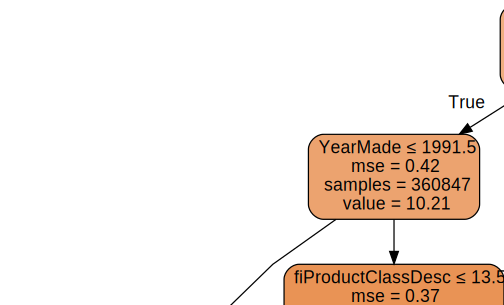

In [49]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

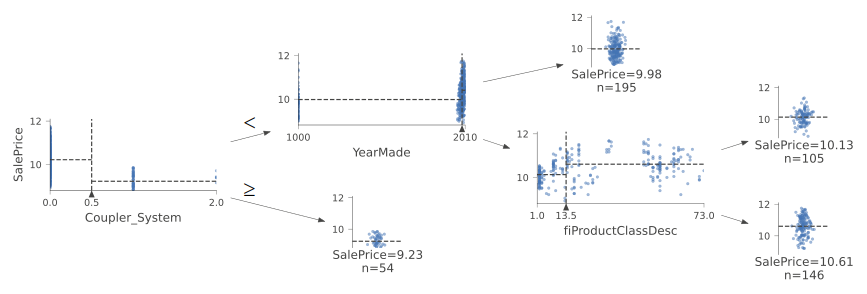

In [50]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [51]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

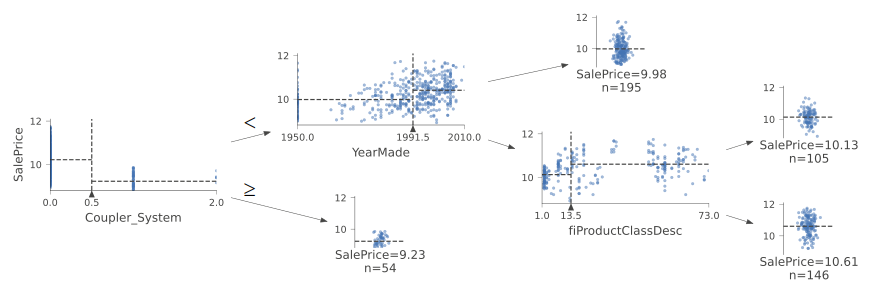

In [52]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [24]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [42]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [26]:
m_rmse(m, xs, y)

0.0

In [27]:
m_rmse(m, valid_xs, valid_y)

0.33011

In [28]:
m.get_n_leaves(), len(xs)

(340829, 404710)

In [29]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.243049, 0.31037)

In [30]:
m.get_n_leaves()

12432

In [26]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [27]:
m = rf(xs, y);

In [33]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171261, 0.23435)

In [34]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [35]:
r_mse(preds.mean(0),valid_y)

0.23435

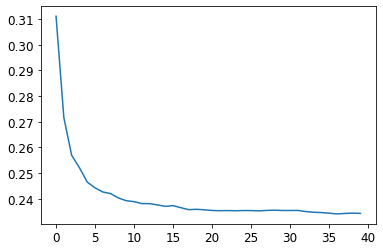

In [36]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [37]:
r_mse(m.oob_prediction_,y)

0.211106

In [38]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [39]:
preds.shape

(40, 7988)

In [40]:
preds_std = preds.std(0)

In [41]:
preds_std[:5]

array([0.26212884, 0.13982203, 0.10917131, 0.21877462, 0.11290124])

In [23]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [28]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.171003
30,Coupler_System,0.107338
6,ProductSize,0.102077
7,fiProductClassDesc,0.079323
54,ModelID,0.053538
32,Hydraulics_Flow,0.051012
65,saleElapsed,0.050275
3,fiSecondaryDesc,0.049979
31,Grouser_Tracks,0.042960
12,Enclosure,0.033896


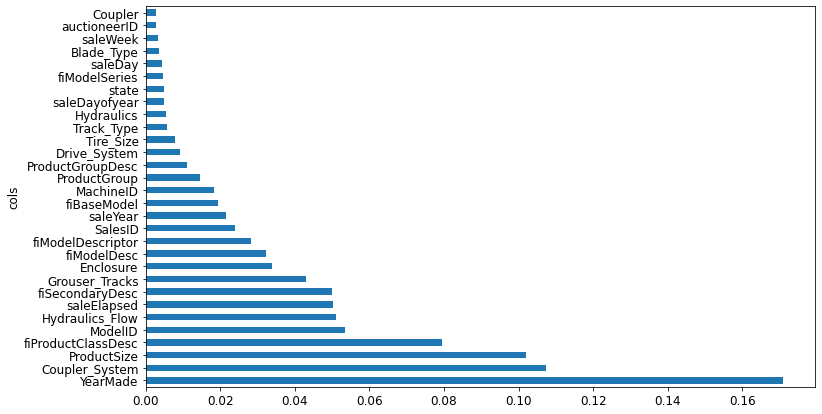

In [29]:
def plot_fi(fi):
    return fi.plot('cols','imp','barh',figsize=(12,7),legend=False)

plot_fi(fi[:30]);

In [30]:
to_keep=fi[fi.imp>0.005].cols
len(to_keep)

23

In [31]:
xs_imp=xs[to_keep]
valid_xs_imp=valid_xs[to_keep]

In [56]:
m=rf(xs_imp,y)

In [57]:
m_rmse(m,xs_imp,y), m_rmse(m,valid_xs_imp, valid_y) #versus all features accuracy (0.171261, 0.23435)

(0.181325, 0.232093)

In [58]:
len(xs.columns), len(xs_imp.columns)

(66, 22)

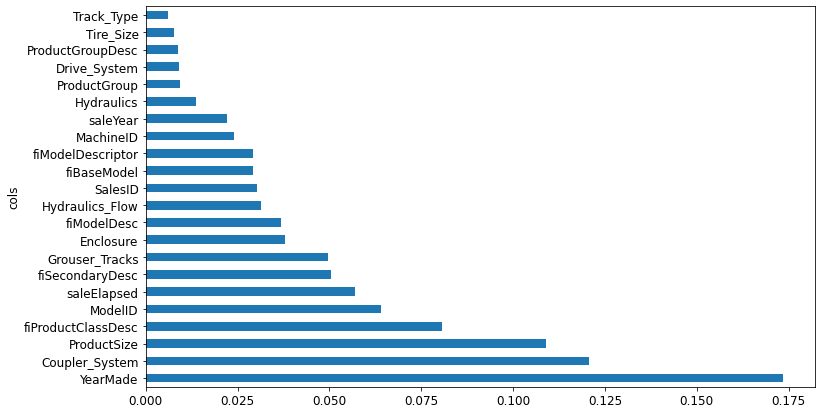

In [59]:
plot_fi(rf_feat_importance(m,xs_imp));

In [64]:
cluster_columns(xs_imp)

ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 720x432 with 0 Axes>

In [32]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15, 
                             max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df,y)
    return m.oob_score_

In [33]:
get_oob(xs_imp)

0.876419966207318

In [34]:
{c:get_oob(xs_imp.drop(c,axis=1)) for c in ('saleYear','saleElapsed','ProductGroupDesc','ProductGroup',
                                          'fiModelDesc','fiBaseModel','Hydraulics_Flow','Grouser_Tracks','Coupler_System')}

{'saleYear': 0.8747151945199763,
 'saleElapsed': 0.8718375110749261,
 'ProductGroupDesc': 0.8762348863382351,
 'ProductGroup': 0.8760226553929351,
 'fiModelDesc': 0.8749170774010411,
 'fiBaseModel': 0.8758760701076508,
 'Hydraulics_Flow': 0.8769255100496436,
 'Grouser_Tracks': 0.8765415623021173,
 'Coupler_System': 0.8762388634610994}

In [35]:
to_drop = ['saleYear','ProductGroupDesc','fiBaseModel','Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8736203430179946

In [36]:
xs_final=xs_imp.drop(to_drop, axis=1)
valid_xs_final=valid_xs_imp.drop(to_drop, axis=1)

In [39]:
(path/'xs_final.pkl').save(xs_final)
(path/'valid_xs_final.pkl').save(valid_xs_final)

In [40]:
xs_final=(path/'xs_final.pkl').load()
valid_xs_final=(path/'valid_xs_final').load()

In [56]:
m=rf(xs_final,y)                                       #versus feature importance accuracy (0.181325, 0.232093)
m_rmse(m,xs_final,y), m_rmse(m,valid_xs_final,valid_y)

(0.180446, 0.23631)

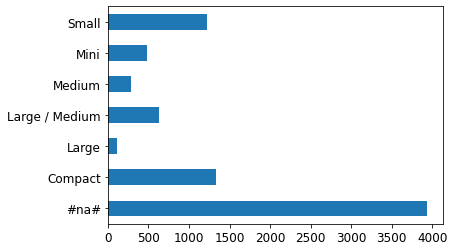

In [44]:
p=valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c=to.classes['ProductSize']
plt.yticks(range(len(c)),c);

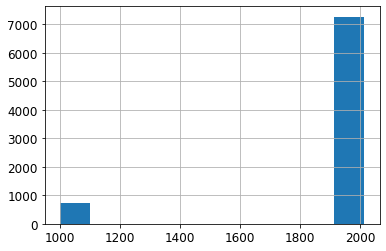

In [54]:
ax = valid_xs_final['YearMade'].hist()

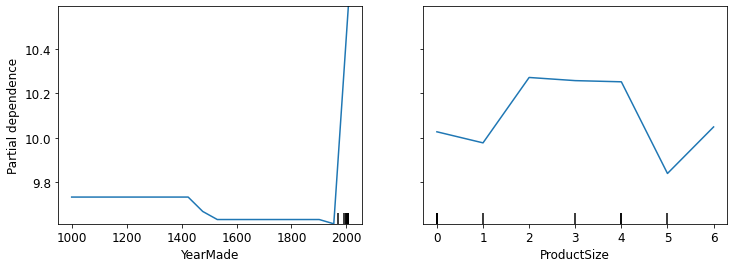

In [57]:
from sklearn.inspection import plot_partial_dependence

fig,ax=plt.subplots(figsize=(12,4))
plot_partial_dependence(m, valid_xs_final, ['YearMade', 'ProductSize'],
                       grid_resolution=20, ax=ax);

In [64]:
import warnings
warnings.simplefilter('ignore',FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [65]:
row = valid_xs_final.iloc[:5]

In [66]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [67]:
prediction[0], bias[0], contributions[0].sum()

(array([9.9846555]), 10.104277090362793, -0.11962158993823843)

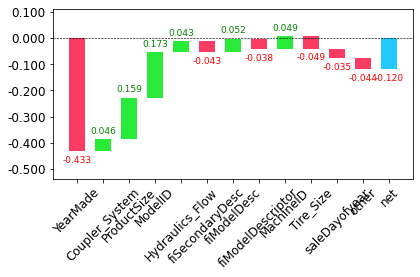

In [69]:
waterfall(valid_xs_final.columns, contributions[0],threshold=0.08, 
         rotation_value=45, formatting='{:,.3f}');